In [1]:
!pip install -q keras
import keras
import keras.backend as K
from keras.layers.core import Activation
from keras.models import Sequential,load_model
from keras.layers import Dense, Dropout, LSTM
from IPython.display import SVG, clear_output
from keras.utils import plot_model
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from sklearn import preprocessing

Using TensorFlow backend.


In [2]:
from google.colab import auth
from googleapiclient.discovery import build
import io , requests, os
import sys
auth.authenticate_user()
from googleapiclient.discovery import build
drive_service = build('drive', 'v3')
!pip install -U -q PyDrive

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# 1. Authenticate and create the PyDrive client.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)
K.tensorflow_backend._get_available_gpus()

[]

In [0]:

# Setting seed for reproducibility
np.random.seed(1234)  
PYTHONHASHSEED = 0

# define path to save model
model_path = 'regression_model_cnn_rnn_rnn__FL001.h5'

In [0]:


# read training data - It is the aircraft engine run-to-failure data.
file_id = '18DPDg7WfvN3UlVQ09jbUhO6n9kWsBCuO'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
train_df = pd.read_csv('xyz.csv', sep=" ", header=None)
#print(train_df)
train_df.drop(train_df.columns[[26, 27]], axis=1, inplace=True)
train_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']
train_df = train_df.sort_values(['id','cycle'])

# read test data - It is the aircraft engine operating data without failure events recorded.
file_id = '1MCbx-H2vV4CsqdsrWtD0oYO7JjZPS8Lz'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
test_df = pd.read_csv('xyz.csv', sep=" ", header=None)
test_df.drop(test_df.columns[[26, 27]], axis=1, inplace=True)
test_df.columns = ['id', 'cycle', 'setting1', 'setting2', 'setting3', 's1', 's2', 's3',
                     's4', 's5', 's6', 's7', 's8', 's9', 's10', 's11', 's12', 's13', 's14',
                     's15', 's16', 's17', 's18', 's19', 's20', 's21']

# read ground truth data - It contains the information of true remaining cycles for each engine in the testing data.
file_id = '1wH-6LT6bTAjxEDO-qDf7PhMq7Z37KUaP'
downloaded = drive.CreateFile({'id': file_id})
downloaded = drive.CreateFile({'id':file_id}) # replace the id with id of file you want to access
downloaded.GetContentFile('xyz.csv')  
truth_df = pd.read_csv('xyz.csv', sep=" ", header=None)
truth_df.drop(truth_df.columns[[1]], axis=1, inplace=True)


In [0]:
# Data Labeling - generate column RUL
rul = pd.DataFrame(train_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
train_df = train_df.merge(rul, on=['id'], how='left')
train_df['RUL'] = train_df['max'] - train_df['cycle']
train_df.drop('max', axis=1, inplace=True)


# MinMax normalization
train_df['cycle_norm'] = train_df['cycle']
cols_normalize = train_df.columns.difference(['id','cycle','RUL'])
min_max_scaler = preprocessing.MinMaxScaler()
norm_train_df = pd.DataFrame(min_max_scaler.fit_transform(train_df[cols_normalize]), 
                             columns=cols_normalize, 
                             index=train_df.index)

join_df = train_df[train_df.columns.difference(cols_normalize)].join(norm_train_df)
train_df = join_df.reindex(columns = train_df.columns)

In [6]:
#@title Default title text
# MinMax normalization
test_df['cycle_norm'] = test_df['cycle']
norm_test_df = pd.DataFrame(min_max_scaler.transform(test_df[cols_normalize]), 
                            columns=cols_normalize, 
                            index=test_df.index)
test_join_df = test_df[test_df.columns.difference(cols_normalize)].join(norm_test_df)
test_df = test_join_df.reindex(columns = test_df.columns)
test_df = test_df.reset_index(drop=True)
print(test_df.head())

# generate column max for test data
rul = pd.DataFrame(test_df.groupby('id')['cycle'].max()).reset_index()
rul.columns = ['id', 'max']
truth_df.columns = ['more']
truth_df['id'] = truth_df.index + 1
truth_df['max'] = rul['max'] + truth_df['more']
truth_df.drop('more', axis=1, inplace=True)

# generate RUL for test data
test_df = test_df.merge(truth_df, on=['id'], how='left')
test_df['RUL'] = test_df['max'] - test_df['cycle']
test_df.drop('max', axis=1, inplace=True)


   id  cycle  setting1  setting2  setting3   s1        s2        s3        s4  \
0   1      1  0.632184  0.750000       0.0  0.0  0.545181  0.310661  0.269413   
1   1      2  0.344828  0.250000       0.0  0.0  0.150602  0.379551  0.222316   
2   1      3  0.517241  0.583333       0.0  0.0  0.376506  0.346632  0.322248   
3   1      4  0.741379  0.500000       0.0  0.0  0.370482  0.285154  0.408001   
4   1      5  0.580460  0.500000       0.0  0.0  0.391566  0.352082  0.332039   

    s5     ...           s13       s14       s15  s16       s17  s18  s19  \
0  0.0     ...      0.220588  0.132160  0.308965  0.0  0.333333  0.0  0.0   
1  0.0     ...      0.264706  0.204768  0.213159  0.0  0.416667  0.0  0.0   
2  0.0     ...      0.220588  0.155640  0.458638  0.0  0.416667  0.0  0.0   
3  0.0     ...      0.250000  0.170090  0.257022  0.0  0.250000  0.0  0.0   
4  0.0     ...      0.220588  0.152751  0.300885  0.0  0.166667  0.0  0.0   

        s20       s21  cycle_norm  
0  0.558140  0

In [0]:
# pick a large window size of 50 cycles
sequence_length = 50

def gen_sequence(id_df, seq_length, seq_cols):
   
    data_array = id_df[seq_cols].values
    num_elements = data_array.shape[0]
    
    # Iterate over two lists in parallel.
    # For example id1 have 192 rows so zip iterate over two following list of numbers (0,112),(50,192)
    # 0 50 from row 0 to row 50
    # 1 51 from row 1 to row 51
    # 2 52 from row 2 to row 52
    # ...
    # 111 191 from row 111 to 191
    for start, stop in zip(range(0, num_elements-seq_length), range(seq_length, num_elements)):
        yield data_array[start:stop, :]
        

In [8]:
# pick the feature columns 
sensor_cols = ['s' + str(i) for i in range(1,22)]
sequence_cols = ['setting1', 'setting2', 'setting3', 'cycle_norm']
sequence_cols.extend(sensor_cols)

val=list(gen_sequence(train_df[train_df['id']==1], sequence_length, sequence_cols))
print(len(val))

# transform each id of the train dataset in a sequence
seq_gen = (list(gen_sequence(train_df[train_df['id']==id], sequence_length, sequence_cols)) 
           for id in train_df['id'].unique())

# generate sequences and convert to np array
seq_array = np.concatenate(list(seq_gen)).astype(np.float32)
print(seq_array.shape)

142
(15631, 50, 25)


In [9]:
# generate labels
def gen_labels(id_df, seq_length, label):
   
    data_array = id_df[label].values
    num_elements = data_array.shape[0]
    return data_array[seq_length:num_elements, :]

label_gen = [gen_labels(train_df[train_df['id']==id], sequence_length, ['RUL']) 
             for id in train_df['id'].unique()]

label_array = np.concatenate(label_gen).astype(np.float32)
label_array.shape


(15631, 1)

In [0]:
def r2_keras(y_true, y_pred):
   
    res =  K.sum(K.square( y_true - y_pred ))
    tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - res/(tot + K.epsilon()) )


In [0]:
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.layers.normalization import BatchNormalization

In [12]:
# Next, we build a deep network. 
# The first layer ==> LSTM layer with 100 units
# Second Layer ==>  LSTM layer with 50 units. 
# Dropout is applied after each LSTM layer to control overfitting. 
# Final layer is a Dense output layer with single unit and Relu activation.
nb_features = seq_array.shape[2]
nb_out = label_array.shape[1]

model = Sequential()
model.add(Conv1D(filters=25, kernel_size=3, padding='same', activation='relu',
                 input_shape=(sequence_length, nb_features)))
model.add(BatchNormalization())

model.add(MaxPooling1D(pool_size=1))
model.add(LSTM(
         units=100,
         return_sequences=True))
model.add(Dropout(0.2))

model.add(LSTM(
          units=50,
          return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=nb_out))
model.add(Activation("linear"))
model.compile(loss='mean_squared_error', optimizer='Adam',metrics=['mae',r2_keras])

print(model.summary())

Instructions for updating:
`NHWC` for data_format is deprecated, use `NWC` instead
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 50, 25)            1900      
_________________________________________________________________
batch_normalization_1 (Batch (None, 50, 25)            100       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 50, 25)            0         
_________________________________________________________________
lstm_1 (LSTM)                (None, 50, 100)           50400     
_________________________________________________________________
dropout_1 (Dropout)          (None, 50, 100)           0         
_________________________________________________________________
lstm_2 (LSTM)                (None, 50)                30200     
___________________________________________________________

In [0]:
# plot
class PlotLosses(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.i = 0
        self.x = []
        self.losses = []
        self.val_losses = []        
        self.fig = plt.figure()        
        self.logs = []

    def on_epoch_end(self, epoch, logs={}):        
        self.logs.append(logs)
        self.x.append(self.i)
        self.losses.append(logs.get('loss'))
        self.val_losses.append(logs.get('val_loss'))
        self.i += 1
        
        clear_output(wait=True)
        plt.plot(self.x, np.sqrt(self.losses), label="loss")
        plt.plot(self.x, np.sqrt(self.val_losses), label="val_loss")
        plt.ylabel('loss - RMSE')
        plt.xlabel('epoch')
        plt.legend(['train','test'], loc='upper left')
        plt.title('model loss = ' + str(min(np.sqrt(self.val_losses))))
        plt.show();
        
plot_losses = PlotLosses()

In [0]:
# fit the network
history = model.fit(seq_array, label_array, epochs=100, batch_size=200, validation_split=0.05, verbose=2,
          callbacks = [keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='min'),
                       keras.callbacks.ModelCheckpoint(model_path,monitor='val_loss', save_best_only=True, mode='min', verbose=0)]
          
                   )

# list all data in history
print(history.history.keys())

#history.save('lstm_rul.h5') 

Train on 14849 samples, validate on 782 samples
Epoch 1/100
 - 54s - loss: 8876.6557 - mean_absolute_error: 75.6926 - r2_keras: -1.7367e+00 - val_loss: 8023.4658 - val_mean_absolute_error: 71.0194 - val_r2_keras: -2.3903e+00
Epoch 2/100
 - 51s - loss: 7914.4037 - mean_absolute_error: 69.7327 - r2_keras: -1.4403e+00 - val_loss: 7492.3376 - val_mean_absolute_error: 67.8650 - val_r2_keras: -2.1380e+00
Epoch 3/100
 - 53s - loss: 7399.3508 - mean_absolute_error: 66.4253 - r2_keras: -1.2782e+00 - val_loss: 7096.8827 - val_mean_absolute_error: 66.6790 - val_r2_keras: -1.9544e+00
Epoch 4/100
 - 53s - loss: 6928.2722 - mean_absolute_error: 63.3261 - r2_keras: -1.1351e+00 - val_loss: 6583.1181 - val_mean_absolute_error: 62.7024 - val_r2_keras: -1.7117e+00
Epoch 5/100
 - 52s - loss: 6491.4106 - mean_absolute_error: 60.2823 - r2_keras: -9.9971e-01 - val_loss: 6130.9644 - val_mean_absolute_error: 58.6395 - val_r2_keras: -1.4994e+00
Epoch 6/100
 - 56s - loss: 6093.0724 - mean_absolute_error: 57.5182

Epoch 24/100
 - 79s - loss: 2172.5818 - mean_absolute_error: 27.3852 - r2_keras: 0.3360 - val_loss: 2052.4145 - val_mean_absolute_error: 27.2919 - val_r2_keras: 0.2811
Epoch 25/100
 - 82s - loss: 2073.2319 - mean_absolute_error: 26.5274 - r2_keras: 0.3665 - val_loss: 1900.4278 - val_mean_absolute_error: 25.4479 - val_r2_keras: 0.3441
Epoch 26/100
 - 81s - loss: 1962.4502 - mean_absolute_error: 25.5365 - r2_keras: 0.4012 - val_loss: 1832.0887 - val_mean_absolute_error: 25.5877 - val_r2_keras: 0.3705
Epoch 27/100
 - 82s - loss: 1869.5892 - mean_absolute_error: 24.6445 - r2_keras: 0.4298 - val_loss: 1741.9888 - val_mean_absolute_error: 25.2600 - val_r2_keras: 0.4011
Epoch 28/100
 - 81s - loss: 1782.7576 - mean_absolute_error: 23.9951 - r2_keras: 0.4559 - val_loss: 1641.4711 - val_mean_absolute_error: 23.5137 - val_r2_keras: 0.4427
Epoch 29/100
 - 80s - loss: 1704.8808 - mean_absolute_error: 23.2385 - r2_keras: 0.4796 - val_loss: 1573.4970 - val_mean_absolute_error: 23.2574 - val_r2_keras:

Epoch 48/100


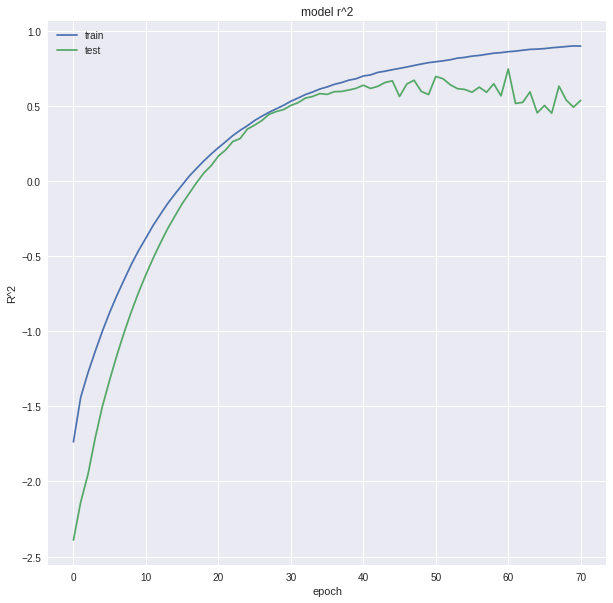

In [15]:
# summarize for R^2
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['r2_keras'])
plt.plot(history.history['val_r2_keras'])
plt.title('model r^2')
plt.ylabel('R^2')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_r2.png")

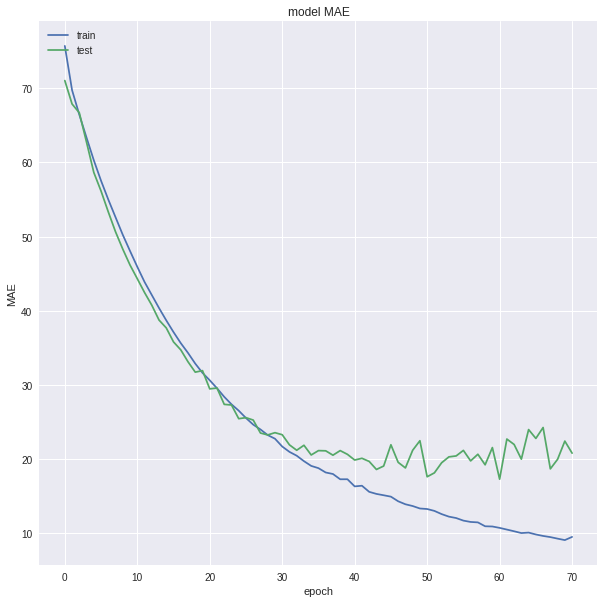

In [16]:

# summarize for MAE
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['mean_absolute_error'])
plt.plot(history.history['val_mean_absolute_error'])
plt.title('model MAE')
plt.ylabel('MAE')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_mae.png")

[8023.465770360454, 7492.337625879156, 7096.8827250839195, 6583.118139710878, 6130.964437265226, 5751.316511149296, 5393.086847876039, 5061.135468075648, 4752.666256019222, 4467.157285880555, 4204.0491993311425, 3955.4416507028254, 3727.380803178948, 3506.301961054887, 3309.175436268682, 3118.742258057265, 2949.3121272328563, 2779.9457146139707, 2626.7752612179806, 2509.2763862317174, 2355.9449178788363, 2243.468718467771, 2108.921074206262, 2052.4145448494446, 1900.4278428646, 1832.08869368219, 1741.988773824004, 1641.4711053170206, 1573.4969651790532, 1518.5248417768942, 1461.2949726855968, 1439.4180347023107, 1337.7928961634332, 1286.4524140418948, 1249.2779637797714, 1257.048069478301, 1185.1932166214185, 1197.2758140466403, 1138.7699584180436, 1105.871844591692, 1050.202949309288, 1080.3312591006384, 1061.2242446470138, 946.7120473720229, 946.8200357344449, 1340.2265303433703, 983.322746296368, 907.4212134475903, 1105.4323758566775, 1173.9192772594558, 777.1934860502668, 854.56969

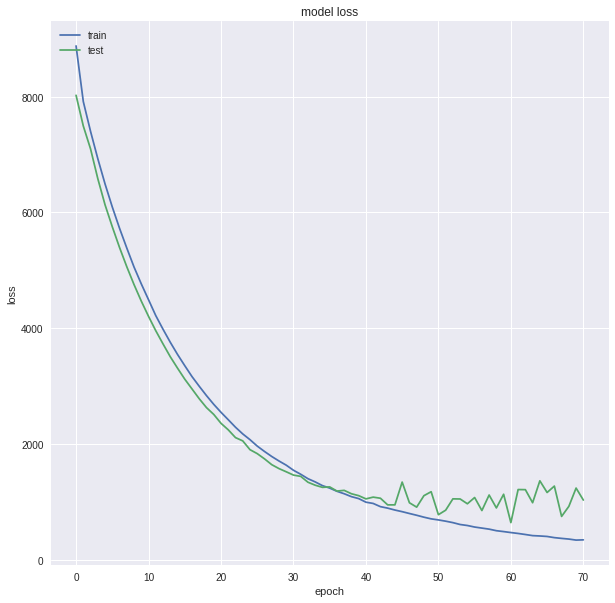

In [17]:
# summarize for Loss
print(history.history['val_loss'])
fig_acc = plt.figure(figsize=(10, 10))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
fig_acc.savefig("model_regression_loss.png")


In [18]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 17s 1ms/step

MAE: 8.71715712787

R^2: 0.910915089945


In [19]:

# training metrics
scores = model.evaluate(seq_array, label_array, verbose=1, batch_size=200)
print('\nMAE: {}'.format(scores[1]))
print('\nR^2: {}'.format(scores[2]))

15631/15631 [==============================] - 17s 1ms/step

MAE: 8.71715712787

R^2: 0.910915089945


In [20]:
y_pred = model.predict(seq_array,verbose=1, batch_size=200)
y_true = label_array
submit = np.concatenate((y_pred, y_true), axis=1)
print(submit)

test_set = pd.DataFrame(y_pred)
test_set.to_csv('submit_train.csv', index = None)


15631/15631 [==============================] - 18s 1ms/step
[[130.71298   141.       ]
 [127.25859   140.       ]
 [127.488365  139.       ]
 ...
 [  2.6693714   2.       ]
 [  1.916769    1.       ]
 [  1.8718439   0.       ]]


In [21]:
# We pick the last sequence for each id in the test data
seq_array_test_last = [test_df[test_df['id']==id][sequence_cols].values[-sequence_length:] 
                       for id in test_df['id'].unique() if len(test_df[test_df['id']==id]) >= sequence_length]

seq_array_test_last = np.asarray(seq_array_test_last).astype(np.float32)
#print("seq_array_test_last")
#print(seq_array_test_last)
#print(seq_array_test_last)

# Similarly, we pick the labels
#print("y_mask")
y_mask = [len(test_df[test_df['id']==id]) >= sequence_length for id in test_df['id'].unique()]
label_array_test_last = test_df.groupby('id')['RUL'].nth(-1)[y_mask].values
label_array_test_last = label_array_test_last.reshape(label_array_test_last.shape[0],1).astype(np.float32)
print(label_array_test_last.shape)
#print("label_array_test_last")
#print(label_array_test_last)


(93, 1)


In [0]:
def score_cal(y_hat, Y_test):
    d   = y_hat - Y_test
    tmp = np.zeros(d.shape[0])
    for i in range(d.shape[0]):
        if d[i,0] >= 0:
           tmp[i] = np.exp( d[i,0]/12) - 1
        else:
           tmp[i] = np.exp(-d[i,0]/15) - 1
    return tmp 


MAE: 12.4675819233

R^2: 0.795430946094
[[ 69.         49.673725 ]
 [ 82.         81.34607  ]
 [ 91.         95.77158  ]
 [ 93.        129.85458  ]
 [ 91.        109.443146 ]
 [ 95.         78.52483  ]
 [111.        146.54805  ]
 [ 96.        100.58847  ]
 [ 97.         74.00069  ]
 [124.        107.73796  ]
 [ 95.        113.918106 ]
 [ 83.        137.76012  ]
 [ 84.        115.291275 ]
 [ 50.         49.995644 ]
 [ 28.         33.42882  ]
 [ 87.         83.45675  ]
 [ 16.         15.367303 ]
 [ 57.         62.080654 ]
 [113.        122.93419  ]
 [ 20.         23.954315 ]
 [119.        116.841545 ]
 [ 66.         71.79913  ]
 [ 97.         96.9845   ]
 [ 90.         82.86262  ]
 [115.         65.73164  ]
 [  8.          9.237823 ]
 [ 48.         49.08998  ]
 [106.        127.615    ]
 [  7.          6.7475567]
 [ 11.         17.882902 ]
 [ 19.         22.323807 ]
 [ 21.         25.03103  ]
 [ 50.         61.70933  ]
 [ 28.         34.045055 ]
 [ 18.         19.633865 ]
 [ 10.        

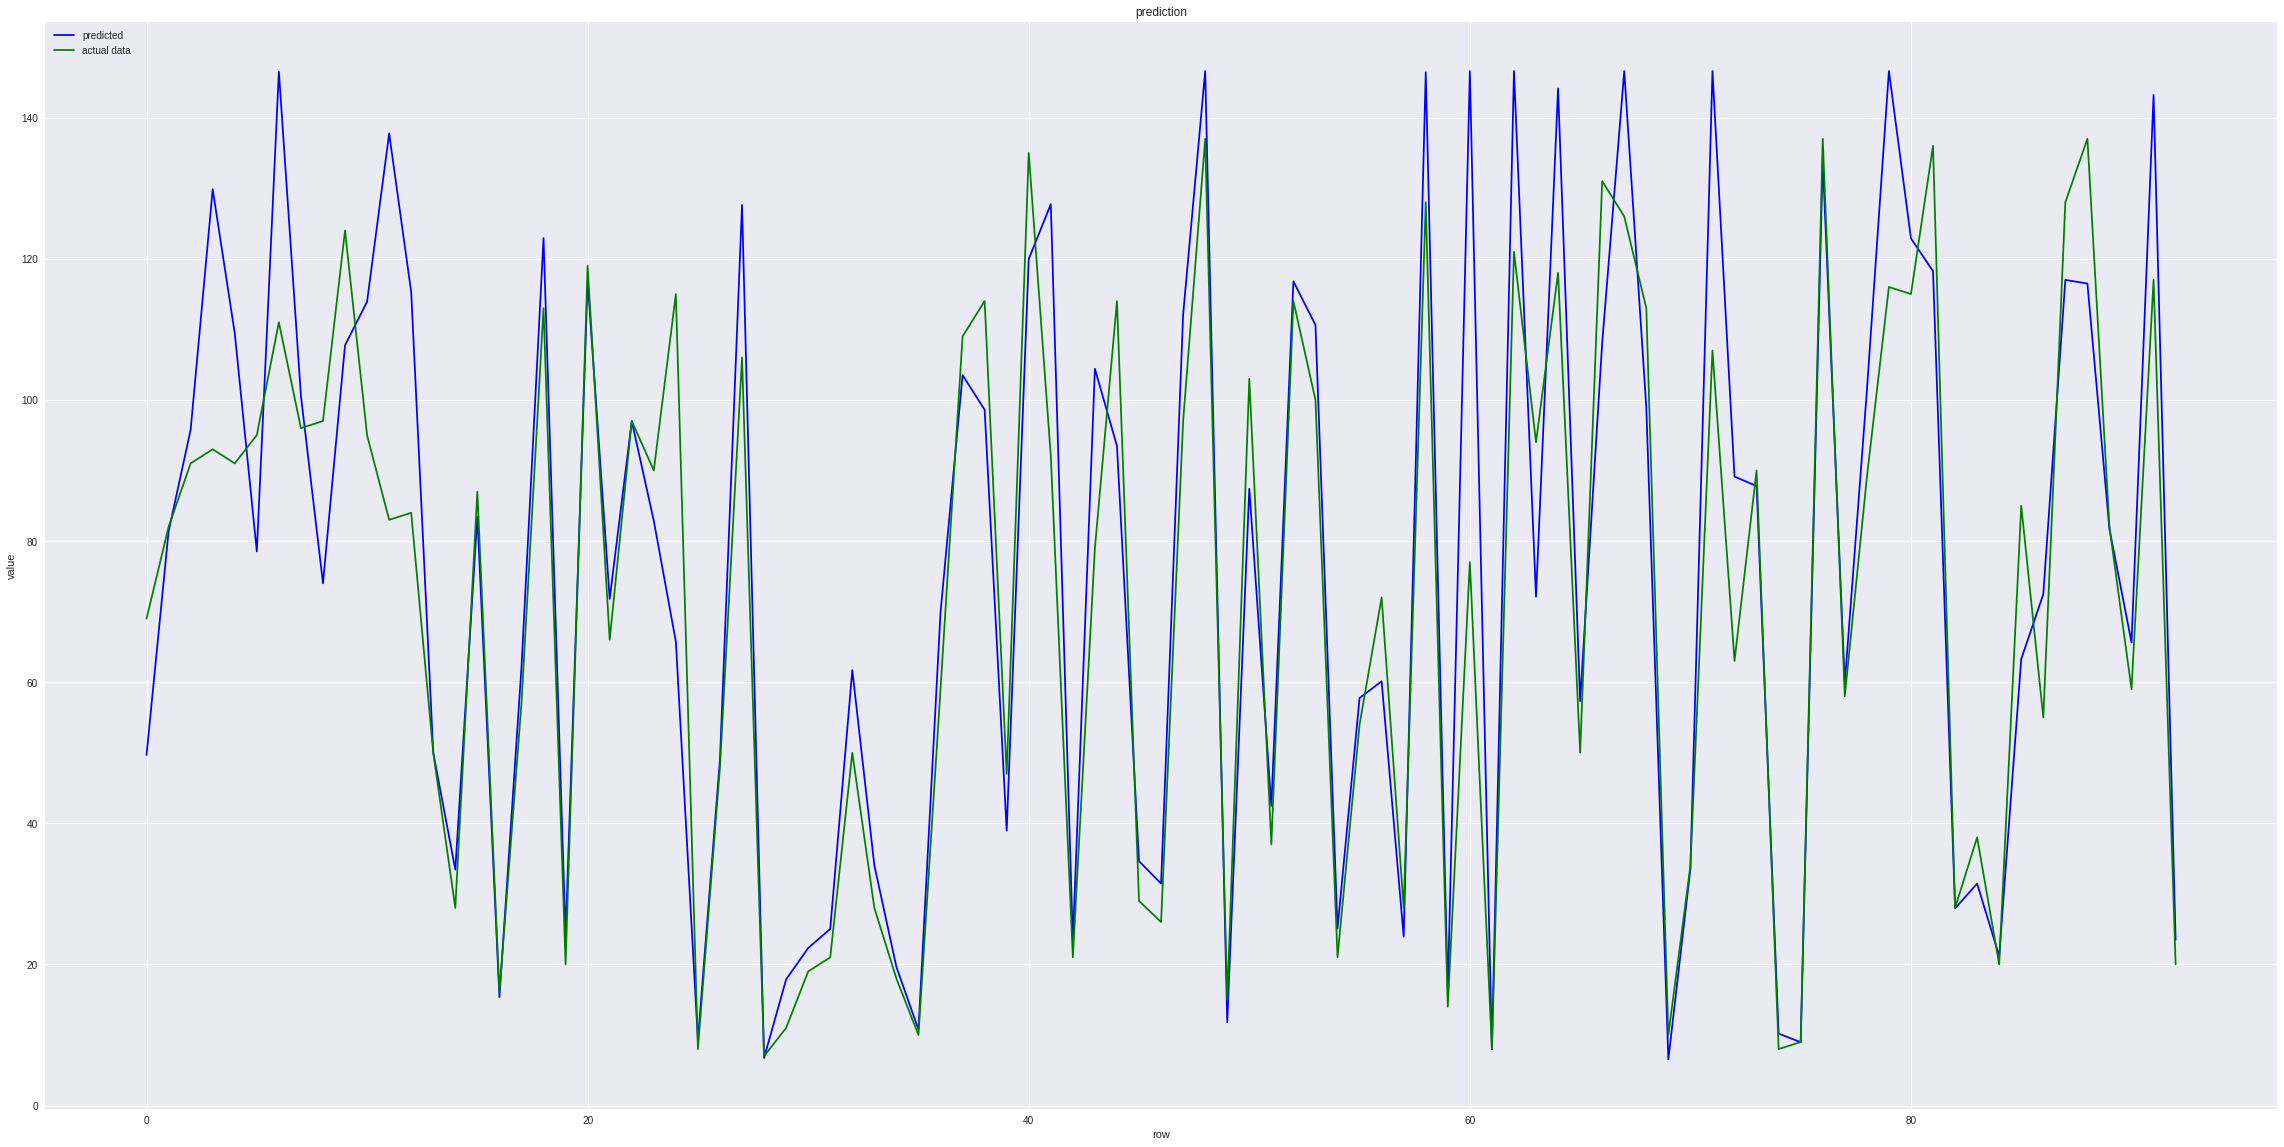

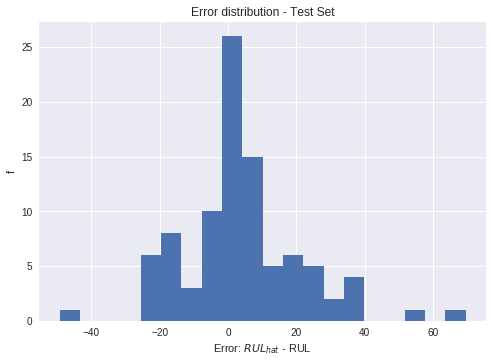

Score = 685.2299001755766


In [23]:
# if best iteration's model was saved then load and use it
if os.path.isfile(model_path):
    estimator = load_model(model_path,custom_objects={'r2_keras': r2_keras})

    # test metrics
    scores_test = estimator.evaluate(seq_array_test_last, label_array_test_last, verbose=2)
    print('\nMAE: {}'.format(scores_test[1]))
    print('\nR^2: {}'.format(scores_test[2]))

    y_pred_test = estimator.predict(seq_array_test_last)
    y_true_test = label_array_test_last

    test_set = pd.DataFrame(y_pred_test)
    submit = np.concatenate((y_true_test, y_pred_test), axis=1)
    print(submit)
    test_set.to_csv('submit_test.csv', index = None)

    # Plot in blue color the predicted data and in green color the
    # actual data to verify visually the accuracy of the model.
    fig_verify = plt.figure(figsize=(40, 20))
    plt.plot(y_pred_test, color="blue")
    plt.plot(y_true_test, color="green")
    plt.title('prediction')
    plt.ylabel('value')
    plt.xlabel('row')
    plt.legend(['predicted', 'actual data'], loc='upper left')
    plt.show()
    fig_verify.savefig("model_regression_verify.png")
    
    d = y_pred_test - y_true_test
    plt.hist(d, bins='auto')  
    plt.title('Error distribution - Test Set')
    plt.ylabel('f')
    plt.xlabel("Error: $RUL_{hat}$ - RUL")
    plt.show()
    
    score_i_tr = score_cal(y_pred_test, y_true_test)
    print("Score = " + str(sum(score_i_tr)))